Please find attached “Brent.csv” which is the daily synthetic price of Brent since 1990. We ask you to propose a trading strategy based on this asset. The strategy is not necessary long only, i.e. you can decide to short the asset (and bet against the asset). You can also be flat some days if you want. The assessment has to be completed in 24 hours.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import talib

For this exercise, I experimented with simple trading strategies and this gave me an understanding of the trends behind the evolution of Brent prices. I know this was a very simple way of looking at the problem and that many parameters were not taken into account. If I had more time, I would include those parameters to produce more precise backtesting results and compare more efficiently the risk-return elements of each one. I would also have included external data (maybe the CPI to account for the bullish or bearish feeling among consumers and the expanding or contracting global demand; I would also have added longer term futures to explore contango and backwardation phenomena.

## Exploring the data

I'm going to start with a quick EDA to get familiar with the data at hand

In [2]:
data = pd.read_csv("Brent.csv")

In [3]:
data

,Unnamed: 0,Brent
0,1990-06-05,96.273671
1,1990-06-06,95.357361
2,1990-06-07,95.357361
3,1990-06-08,95.601710
4,1990-06-11,95.601710
...,...,...
8052,2022-09-26,929.447199
8053,2022-09-27,951.993528
8054,2022-09-28,987.663841
8055,2022-09-29,977.904981


The dataset is composed of two columns: every trading day since 1990-06-05 up until 2022-09-30 and the synthetic price of Brent for each of those days.

In [4]:
data.describe()

,Brent
count,8057.000000
mean,662.381683
std,457.020965
min,93.271419
25%,262.348732
50%,555.817849
75%,1023.447452
max,2449.760442


As we can see, there were significant variations of the synthetic price of Brent for the given period, given the min/max values and the std. Let's now clean the data from possible missing values, turn the time column values into datetime format and plot our data

In [5]:
data.isnull().sum()

Unnamed: 0    0
Brent         0
dtype: int64

In [6]:
data.dtypes

Unnamed: 0     object
Brent         float64
dtype: object

In [7]:
data['date'] = pd.to_datetime(data['Unnamed: 0'])
data.set_index('date', inplace=True)

In [8]:
data.drop('Unnamed: 0', axis=1, inplace=True)

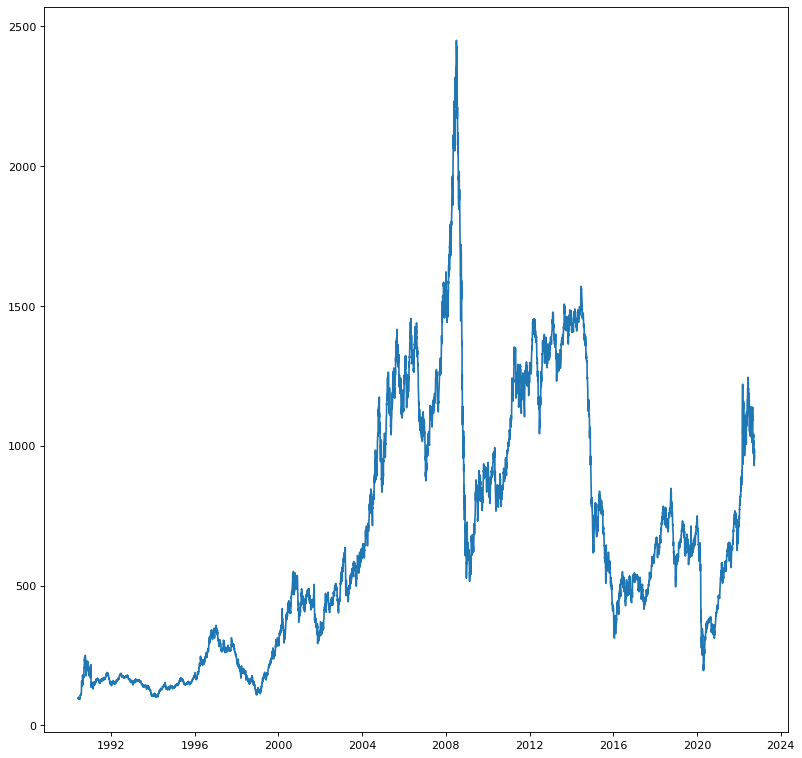

In [9]:
figure(figsize=(12, 12), dpi=80)
plt.plot(data)

We can see strong evolutions in the synthetic price of Brent. A general rise until the 2008 financial crisis (with a fall in 1997/8 certainly due to the Asian crisis), and then the 2008 crash. Rising again until 2014 to suffer another trough due to weaker global demand and increased US shale oil production. Then another fall in 2020 linked to the Covid pandemic. The price has greatly evolved during the period and this can be linked with major global economic events

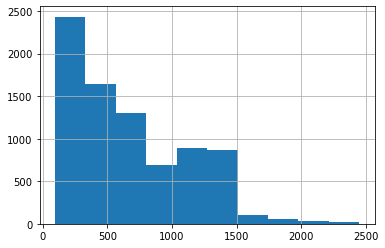

In [10]:
data['Brent'].hist()
plt.show()

## Holding strategy

In [11]:
(data["Brent"][-1] - data["Brent"][0]) / (data["Brent"][0])

8.919868289365414

If one had adopted a holding strategy between the beginning of the period and the end of the period, it would have yielded a 892% return over the period. We can use this metric to compare this to the trading strategies we will define. Let's now add a daily returns column to our dataset, which we will then use in the following

In [12]:
data['returns'] = data['Brent'].pct_change()

In [13]:
data.fillna(0, inplace=True)

## First trading strategy: momentum

My first idea is to use a momentum-based trading strategy, where strong current upwards momentums in the price mean we should long the asset, and short it otherwise. To do this, I'm going to compute several moving averages for common time periods (9, 21, 30, 60, 120 days) and compare some to others to define if I long or short Brent. For instance, I will compare the 9-day moving average to the 30, 60 and 120 days MA, then the 21 to 60 and 120, and then the 30 to 120 MA, in order to compare shorter-term MA to longer-term MA. If Brent prices have a strong upward or downward trend, then this strategy is likely to yield positive results. I will be using the TA-library for moving averages computations.

In [14]:
data_copy = data.copy()

In [15]:
time_periods = [9, 21, 30, 60, 120]

for period in time_periods:
    column_name = 'ma_' + str(period)
    data_copy[column_name] = talib.SMA(data_copy['Brent'], timeperiod=period)

In [16]:
data_copy.dropna(inplace=True)

In [17]:
data_copy['position_9_30'] = np.where(data_copy['ma_9'] > data_copy['ma_30'], 1, -1)
data_copy['position_9_60'] = np.where(data_copy['ma_9'] > data_copy['ma_60'], 1, -1)
data_copy['position_9_120'] = np.where(data_copy['ma_9'] > data_copy['ma_120'], 1, -1)
data_copy['position_21_60'] = np.where(data_copy['ma_21'] > data_copy['ma_60'], 1, -1)
data_copy['position_21_120'] = np.where(data_copy['ma_21'] > data_copy['ma_120'], 1, -1)
data_copy['position_30_120'] = np.where(data_copy['ma_30'] > data_copy['ma_120'], 1, -1)

In [18]:
data_copy['returns2'] = data_copy['returns'].shift(-1)
data_copy['returns2'].fillna(0, inplace=True)

In [19]:
for col in data_copy.columns:
    if 'position' in col:
        data_copy[col+'_pnl'] = data_copy[col] * data_copy['returns2']

In [20]:
for col in data_copy.columns:
    if '_pnl' in col:
        final_return = (1 + data_copy[col]).prod()
        print(f"the final return for {col} is: {final_return}")

the final return for position_9_30_pnl is: 14.524240597220803
the final return for position_9_60_pnl is: 13.007308806649721
the final return for position_9_120_pnl is: 2.654928438840394
the final return for position_21_60_pnl is: 3.2547351082916776
the final return for position_21_120_pnl is: 2.3837452800851837
the final return for position_30_120_pnl is: 20.362659439844965


These strategies seem to yield high returns, especially the 9/30, 9/60 and 30/120 momentum strategies. The returns of these strategies are significantly higher than the holding strategy

For more precise backtesting, let me assume that the number of trading days per year is 252 and that the average risk-free during that period was around 4%.

In [21]:
trading_days_per_year = 252
risk_free_rate = 0.04
for col in data_copy.columns:
    if '_pnl' in col:
        pnl_col = data_copy[col]
        average_annual_return = (1 + pnl_col).prod() ** (252/len(pnl_col)) - 1
        annual_std = pnl_col.std() * np.sqrt(252)
        sharpe_ratio = (average_annual_return - risk_free_rate) / (pnl_col.std() * np.sqrt(252))
        cumulative_returns = (1 + pnl_col).cumprod()
        cumulative_returns = cumulative_returns / cumulative_returns.cummax() - 1
        max_dd = cumulative_returns.min()
        print(f"the average annual return for {col} is: {average_annual_return}")
        print(f"The sharpe ratio for {col} is: {sharpe_ratio}")
        print(f"The maximum drawdown for the {col} is: {max_dd}\n")

the average annual return for position_9_30_pnl is: 0.0886589694294111
The sharpe ratio for position_9_30_pnl is: 0.13725663525785015
The maximum drawdown for the position_9_30_pnl is: -0.7359233091211947

the average annual return for position_9_60_pnl is: 0.08485333944466422
The sharpe ratio for position_9_60_pnl is: 0.12651933181761083
The maximum drawdown for the position_9_60_pnl is: -0.7775725798087078

the average annual return for position_9_120_pnl is: 0.03148280896142719
The sharpe ratio for position_9_120_pnl is: -0.024020232103697733
The maximum drawdown for the position_9_120_pnl is: -0.8389572221525714

the average annual return for position_21_60_pnl is: 0.03817445378706186
The sharpe ratio for position_21_60_pnl is: -0.005148506449143055
The maximum drawdown for the position_21_60_pnl is: -0.7939394722005906

the average annual return for position_21_120_pnl is: 0.02796068012253361
The sharpe ratio for position_21_120_pnl is: -0.03395302084379611
The maximum drawdown fo

As we can see, the annualized returns are correct for our 3 selected (8-10%) strategies. However, the maximum drawdowns indicate risky strategies which might be difficult to put in place over time, and this is confirmed by the quite low Sharpe ratios: these strategies do not have an optimal risk-reward ratio.

I know that these numbers for profits are very high and many things are not taken into account, such as volume, transaction costs, slippage, risk limits... I wanted to experiment simple strategies with our dataset even though the returns from these strategies could not have been as high in reality

## Second strategy: mean reversion

I want to try a second strategy, mean reversion. Maybe Brent prices tend to move towards a long-term average ? Let's find out if this is profitable.

In [22]:
data_copy = data.copy()

In [23]:
time_periods = [9, 21, 30, 60, 120]

for period in time_periods:
    column_name = 'ma_' + str(period)
    data_copy[column_name] = talib.SMA(data_copy['Brent'], timeperiod=period)

In [24]:
data_copy.dropna(inplace=True)

In [25]:
for i in range(len(data_copy.columns)):
    if data_copy.columns[i] in ['ma_9', 'ma_21', 'ma_30', 'ma_60', 'ma_120']:
        data_copy[data_copy.columns[i]+'_pos'] = np.where(data_copy[data_copy.columns[i]] > data_copy['Brent'], 1, -1)

I am comparing the daily synthetic prices with the 9, 21, 30, 60 and 120 days moving averages, and taking a long or short position in consequence

In [26]:
data_copy['returns2'] = data_copy['returns'].shift(-1)
data_copy['returns2'].fillna(0, inplace=True)

In [27]:
for col in data_copy.columns:
    if '_pos' in col:
        data_copy[col+'_pnl'] = data_copy[col] * data_copy['returns2']

In [28]:
for col in data_copy.columns:
    if '_pnl' in col:
        final_return = (1 + data_copy[col]).cumprod().iloc[-1]
        print(f"the final return for {col} is: {final_return}")

the final return for ma_9_pos_pnl is: 0.04611364175336729
the final return for ma_21_pos_pnl is: 0.00441006927595442
the final return for ma_30_pos_pnl is: 0.0031956779450152315
the final return for ma_60_pos_pnl is: 0.002621057114275533
the final return for ma_120_pos_pnl is: 0.0014591380144085876


The cumulated returns are very close to 0, so I will drop these mean reversion strategies. Maybe they could have worked better with additional parameters and criteria.

## Trying volatility strategies

Then, let's try some strategies based on the volatility of the asset, using Bollinger Bands and RSI indicators. If the asset is overbought, we will sell it from the hypothesis that it will be corrected, and the inverse if it is oversold.

In [29]:
data_copy = data.copy()

In [30]:
data_copy['bb_upper'], data_copy['bb_middle'], data_copy['bb_lower'] = talib.BBANDS(data_copy['Brent'], timeperiod=20)
data_copy['RSI'] = talib.RSI(data_copy['Brent'])
data_copy['bband_pos'] = np.where(data_copy['Brent'] < data_copy['bb_lower'], 1,
                                  np.where(data_copy['Brent'] > data_copy['bb_upper'], -1, 0))
data_copy['rsi_pos'] = np.where(data_copy['RSI'] < 30, 1, np.where(data_copy['RSI'] > 70, -1, 0))

If the current price is over the Bollinger upper band, it is overbought so we short it. Same if it is above an RSI of 70. And we short it if it's under the Bollinger lower band or under an RSI of 30. 

In [31]:
data_copy.dropna(inplace=True)

In [32]:
data_copy['returns2'] = data_copy['returns'].shift(-1)
data_copy['returns2'].fillna(0, inplace=True)

In [33]:
for col in data_copy.columns:
    if '_pos' in col:
        data_copy[col+'_pnl'] = data_copy[col] * data_copy['returns2']

In [34]:
for col in data_copy.columns:
    if '_pnl' in col:
        pnl_col = data_copy[col]
        average_annual_return = (1 + pnl_col).prod() ** (252/len(pnl_col)) - 1
        annual_std = pnl_col.std() * np.sqrt(252)
        sharpe_ratio = (average_annual_return - risk_free_rate) / (pnl_col.std() * np.sqrt(252))
        cumulative_returns = (1 + pnl_col).cumprod()
        cumulative_returns = cumulative_returns / cumulative_returns.cummax() - 1
        max_dd = cumulative_returns.min()
        print(f"the average annual return for {col} is: {average_annual_return}")
        print(f"The sharpe ratio for {col} is: {sharpe_ratio}")
        print(f"The maximum drawdown for the {col} is: {max_dd}\n")

the average annual return for bband_pos_pnl is: 0.00508269156448149
The sharpe ratio for bband_pos_pnl is: -0.23527358322027073
The maximum drawdown for the bband_pos_pnl is: -0.6360073381549383

the average annual return for rsi_pos_pnl is: -0.06269271747152594
The sharpe ratio for rsi_pos_pnl is: -0.6464646230917407
The maximum drawdown for the rsi_pos_pnl is: -0.8893566792916671



Returns for this strategy are null or negative so I will drop these strategies based on volatility and overbought/oversold criteria. Given more time, maybe I could have optimized the timeperiods for these criteria, as well as the RSI thresholds, to find better working strategies

# Combining momentum and volatility

Now, I will try to combine some of my best momentum-based strategies with volatility indicators. Maybe this will allow to reduce the risk and maximum drawdown of these strategies ?

In [35]:
data_copy = data.copy()

In [36]:
time_periods = [9, 30, 60, 120]

for period in time_periods:
    column_name = 'ma_' + str(period)
    data_copy[column_name] = talib.SMA(data_copy['Brent'], timeperiod=period)

In [37]:
data_copy['bb_upper'], data_copy['bb_middle'], data_copy['bb_lower'] = talib.BBANDS(data_copy['Brent'], timeperiod=20)
data_copy['RSI'] = talib.RSI(data_copy['Brent'])

In [38]:
data_copy.dropna(inplace=True)

Selecting the 9/30, 9/60 and 30/120 strategies, I will combine those with Bollinger bands and RSI criteria.

In [39]:
data_copy['position_9_30_rsi'] = np.where((data_copy['ma_9'] > data_copy['ma_30']) & (data_copy['RSI'] < 30), 1,
                                          np.where((data_copy['ma_9'] < data_copy['ma_30']) &
                                                   (data_copy['RSI'] > 70), -1, 0))
data_copy['position_9_60_rsi'] = np.where((data_copy['ma_9'] > data_copy['ma_60']) & (data_copy['RSI'] < 30), 1,
                                          np.where((data_copy['ma_9'] < data_copy['ma_60']) &
                                                   (data_copy['RSI'] > 70), -1, 0))
data_copy['position_30_120_rsi'] = np.where((data_copy['ma_30'] > data_copy['ma_120']) & (data_copy['RSI'] < 30), 1,
                                          np.where((data_copy['ma_30'] < data_copy['ma_120']) &
                                                   (data_copy['RSI'] > 70), -1, 0))


data_copy['position_9_30_bb'] = np.where((data_copy['ma_9'] > data_copy['ma_30']) &
                                         (data_copy['Brent'] < data_copy['bb_lower']), 1,
                                          np.where((data_copy['ma_9'] < data_copy['ma_30']) & 
                                           (data_copy['Brent'] > data_copy['bb_upper']), -1, 0))
data_copy['position_9_60_bb'] = np.where((data_copy['ma_9'] > data_copy['ma_60']) &
                                         (data_copy['Brent'] < data_copy['bb_lower']), 1,
                                          np.where((data_copy['ma_9'] < data_copy['ma_60']) & 
                                           (data_copy['Brent'] > data_copy['bb_upper']), -1, 0))
data_copy['position_30_120_bb'] = np.where((data_copy['ma_30'] > data_copy['ma_120']) &
                                         (data_copy['Brent'] < data_copy['bb_lower']), 1,
                                          np.where((data_copy['ma_30'] < data_copy['ma_120']) & 
                                           (data_copy['Brent'] > data_copy['bb_upper']), -1, 0))


In [40]:
data_copy['returns2'] = data_copy['returns'].shift(-1)
data_copy['returns2'].fillna(0, inplace=True)

In [41]:
for col in data_copy.columns:
    if 'position' in col:
        data_copy[col+'_pnl'] = data_copy[col] * data_copy['returns2']

In [42]:
for col in data_copy.columns:
    if '_pnl' in col:
        pnl_col = data_copy[col]
        average_annual_return = (1 + pnl_col).prod() ** (252/len(pnl_col)) - 1
        annual_std = pnl_col.std() * np.sqrt(252)
        sharpe_ratio = (average_annual_return - risk_free_rate) / (pnl_col.std() * np.sqrt(252))
        cumulative_returns = (1 + pnl_col).cumprod()
        cumulative_returns = cumulative_returns / cumulative_returns.cummax() - 1
        max_dd = cumulative_returns.min()
        print(f"the average annual return for {col} is: {average_annual_return}")
        print(f"The sharpe ratio for {col} is: {sharpe_ratio}")
        print(f"The maximum drawdown for the {col} is: {max_dd}\n")

the average annual return for position_9_30_rsi_pnl is: 0.0027130342407597485
The sharpe ratio for position_9_30_rsi_pnl is: -2.9879370552980014
The maximum drawdown for the position_9_30_rsi_pnl is: -0.01834862385321112

the average annual return for position_9_60_rsi_pnl is: 0.001271359937144334
The sharpe ratio for position_9_60_rsi_pnl is: -2.0707058326240264
The maximum drawdown for the position_9_60_rsi_pnl is: -0.10642201834862375

the average annual return for position_30_120_rsi_pnl is: 0.0014383681163092632
The sharpe ratio for position_30_120_rsi_pnl is: -0.7419557480544834
The maximum drawdown for the position_30_120_rsi_pnl is: -0.23205440298517843

the average annual return for position_9_30_bb_pnl is: 0.0036022731339666603
The sharpe ratio for position_9_30_bb_pnl is: -0.7201473461088765
The maximum drawdown for the position_9_30_bb_pnl is: -0.1812388930992801

the average annual return for position_9_60_bb_pnl is: 0.005589876367536384
The sharpe ratio for position_9_60_

As we can see, returns are close to null so this does not work. For the moment, the best working strategies were simple momentum-based strategy, especially the 30/120. It seems that Brent prices follow short term trends and are quite affected by momentum. I'm keeping in mind that this is a very simple, maybe naive analysis and that many crucial parameters for trading strategies, affecting yields, are not taken into account. 

# MACD

Before ending this analysis, I wanted to try a last strategy using other TA-lib criteria. I hesitated between stochastic oscillator, CCI and MACD, but chose MACD since the two formers are linked to overbought/oversold indicators and this has yielded lesser returns in my previous analysis. The trigger to long or short assets will be when the MACD crosses our signal line (if it crosses above long, if it crosses below short)

In [43]:
data_copy = data.copy()

In [44]:
macd, macd_signal, macd_hist = talib.MACD(data_copy['Brent'])
data_copy['position_macd'] = np.where(macd > macd_signal, 1, np.where(macd < macd_signal, -1, 0))

In [45]:
data_copy['returns2'] = data_copy['returns'].shift(-1)
data_copy['returns2'].fillna(0, inplace=True)

In [46]:
data_copy

,Brent,returns,position_macd,returns2
date,,,,
1990-06-05,96.273671,0.000000,0,-0.009518
1990-06-06,95.357361,-0.009518,0,0.000000
1990-06-07,95.357361,0.000000,0,0.002562
1990-06-08,95.601710,0.002562,0,0.000000
1990-06-11,95.601710,0.000000,0,0.056250
...,...,...,...,...
2022-09-26,929.447199,-0.024260,-1,0.024258
2022-09-27,951.993528,0.024258,-1,0.037469
2022-09-28,987.663841,0.037469,-1,-0.009881


In [47]:
data_copy['macd_pnl'] = data_copy["position_macd"] * data_copy['returns2']

In [48]:
pnl_col = data_copy['macd_pnl']
average_annual_return = (1 + pnl_col).prod() ** (252/len(pnl_col)) - 1
annual_std = pnl_col.std() * np.sqrt(252)
sharpe_ratio = (average_annual_return - risk_free_rate) / (pnl_col.std() * np.sqrt(252))
cumulative_returns = (1 + pnl_col).cumprod()
cumulative_returns = cumulative_returns / cumulative_returns.cummax() - 1
max_dd = cumulative_returns.min()
print("the average annual return for macd is:", average_annual_return)
print("The sharpe ratio for macd is:", sharpe_ratio)
print("The maximum drawdown for macd is:", max_dd)

the average annual return for macd is: -0.0061212404238082385
The sharpe ratio for macd is: -0.12755970089563679
The maximum drawdown for macd is: -0.7888642033471782


Not great !